In [1]:
import numpy as np
import pandas as pd
train_data = pd.read_csv('E:\\private\\学习\\上课资料\\数据\\porto-seguro-safe-driver-prediction\\train.csv')
test_data = pd.read_csv('E:\\private\\学习\\上课资料\\数据\\porto-seguro-safe-driver-prediction\\test.csv')


In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
id                595212 non-null int64
target            595212 non-null int64
ps_ind_01         595212 non-null int64
ps_ind_02_cat     595212 non-null int64
ps_ind_03         595212 non-null int64
ps_ind_04_cat     595212 non-null int64
ps_ind_05_cat     595212 non-null int64
ps_ind_06_bin     595212 non-null int64
ps_ind_07_bin     595212 non-null int64
ps_ind_08_bin     595212 non-null int64
ps_ind_09_bin     595212 non-null int64
ps_ind_10_bin     595212 non-null int64
ps_ind_11_bin     595212 non-null int64
ps_ind_12_bin     595212 non-null int64
ps_ind_13_bin     595212 non-null int64
ps_ind_14         595212 non-null int64
ps_ind_15         595212 non-null int64
ps_ind_16_bin     595212 non-null int64
ps_ind_17_bin     595212 non-null int64
ps_ind_18_bin     595212 non-null int64
ps_reg_01         595212 non-null float64
ps_reg_02         595212 non-null float64
ps_re

In [3]:
#-1为缺失值，看下有多少缺失值
missing_cols= [(col, train_data[train_data[col] == -1][col].count()/595212*100)  for col in train_data.columns if train_data[train_data[col] == -1][col].count() > 0]
missing_cols

[('ps_ind_02_cat', 0.036289590935666624),
 ('ps_ind_04_cat', 0.013944611331760785),
 ('ps_ind_05_cat', 0.975954785857812),
 ('ps_reg_03', 18.106489788512327),
 ('ps_car_01_cat', 0.01797678810239041),
 ('ps_car_02_cat', 0.0008400368272145051),
 ('ps_car_03_cat', 69.08983689844963),
 ('ps_car_05_cat', 44.78253126617071),
 ('ps_car_07_cat', 1.9302366215734896),
 ('ps_car_09_cat', 0.09559619093701067),
 ('ps_car_11', 0.0008400368272145051),
 ('ps_car_12', 0.000168007365442901),
 ('ps_car_14', 7.160473915176441)]

ps_car_03_cat,ps_car_05_cat缺失高达百分之40以上，这里先将这个两个feature去掉

In [4]:
select_cols = list(train_data.columns.values)
select_cols.remove('ps_car_03_cat')
select_cols.remove('ps_car_05_cat')
select_cols.remove('id')
select_cols.remove('target')

In [5]:
#使用中位数补缺失值
for col in select_cols:
    train_data[col].replace(-1, train_data[col].median(), inplace=True)
    test_data[col].replace(-1, train_data[col].median(), inplace=True)

In [6]:
missing_cols= [(col, train_data[train_data[col] == -1][col].count()/595212*100)  for col in train_data.columns if train_data[train_data[col] == -1][col].count() > 0]
missing_cols

[('ps_car_03_cat', 69.08983689844963), ('ps_car_05_cat', 44.78253126617071)]

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
#查看下target的样本情况
train_data['target'].value_counts().plot(kind='bar')

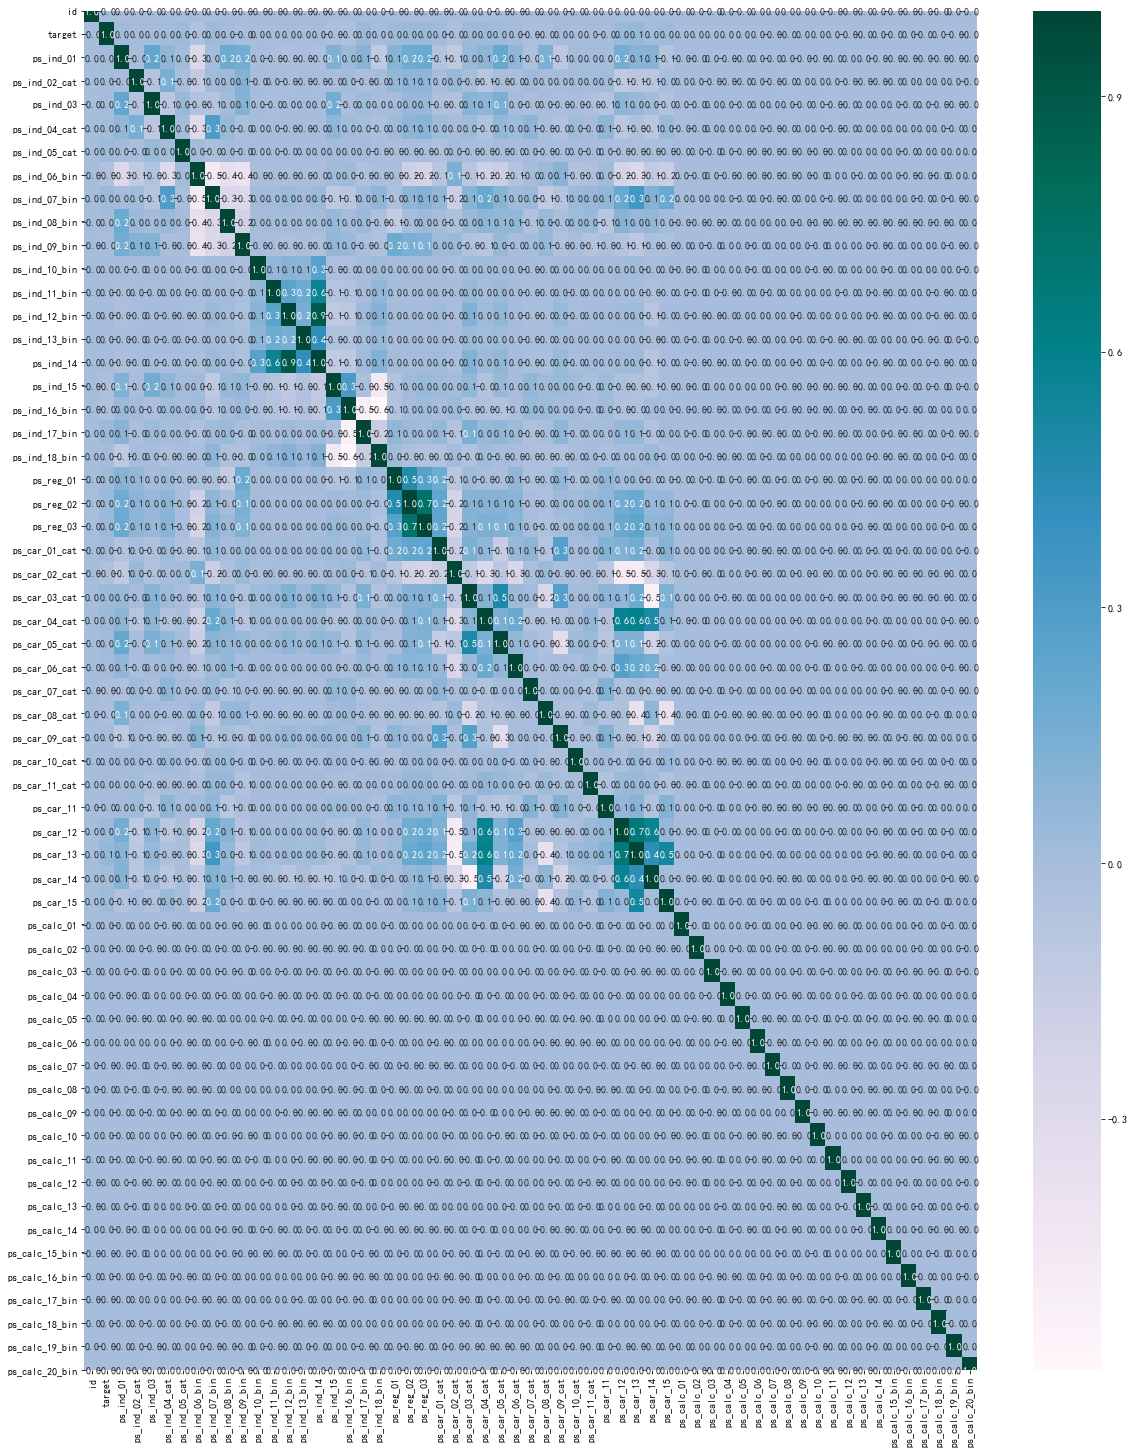

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
corr = train_data.corr()
corr = corr[abs(corr)>=-.01]
fig = plt.figure(figsize=(20,25))
sns.heatmap(corr, annot=True, cmap='PuBuGn',fmt='.1f')

calc开头的字段相关系数都为0？是否可用？

In [9]:
cat_cols = [col for col in select_cols if col.endswith('cat')]
bin_cols = [col for col in select_cols if col.endswith('bin')]
other_cols = [col for col in select_cols if col not in cat_cols+bin_cols]

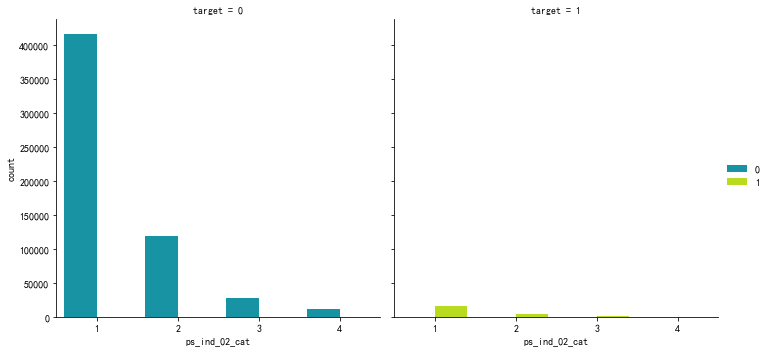

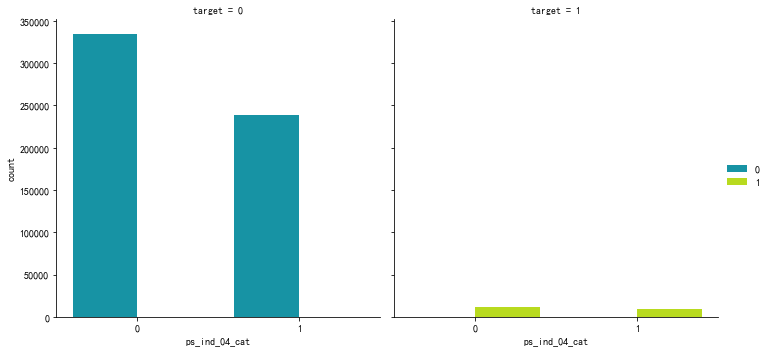

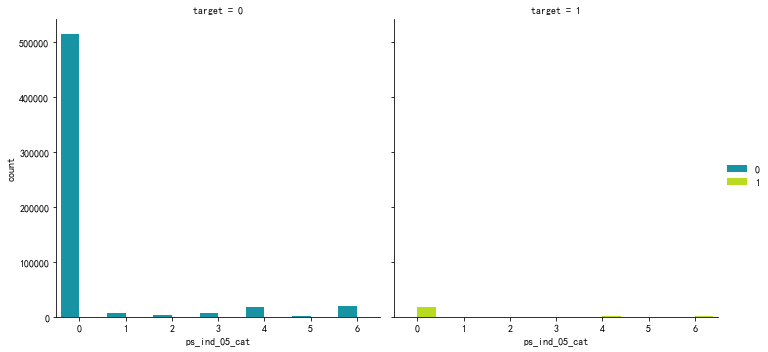

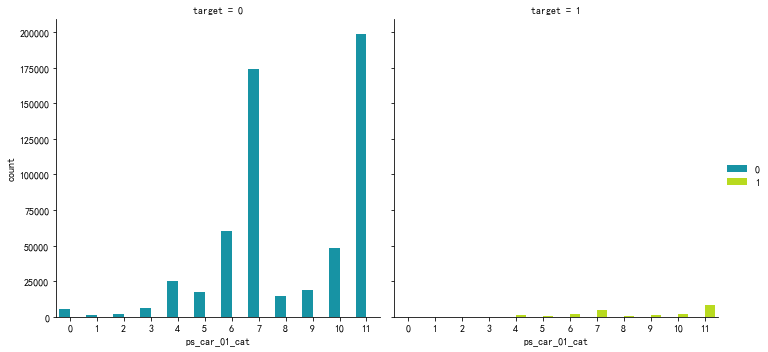

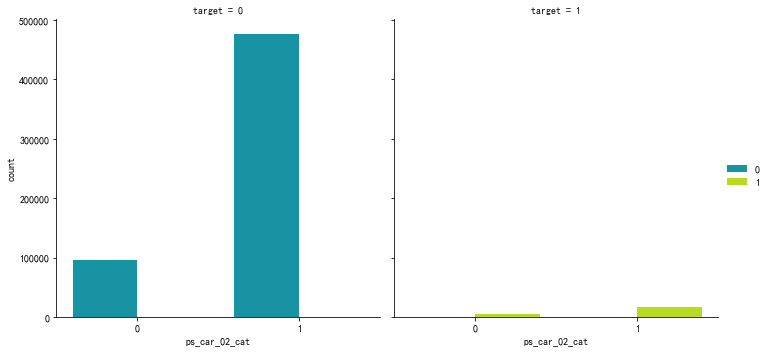

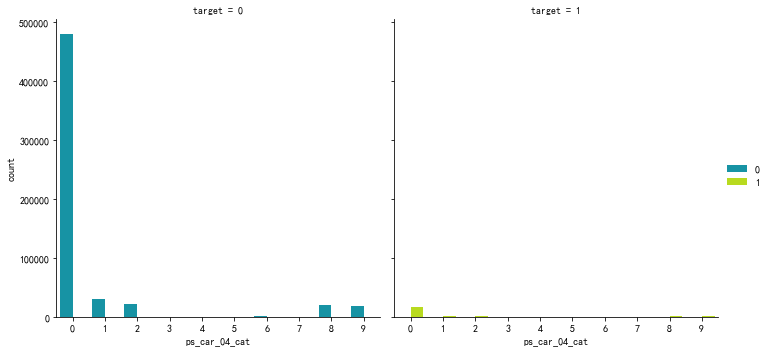

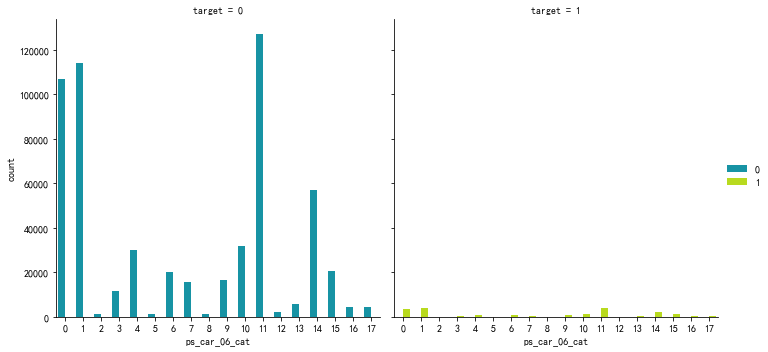

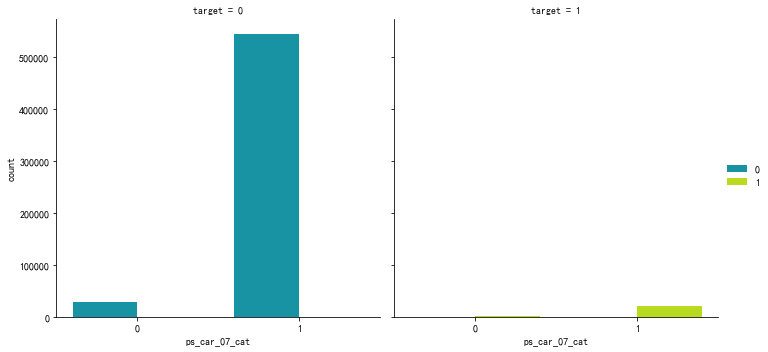

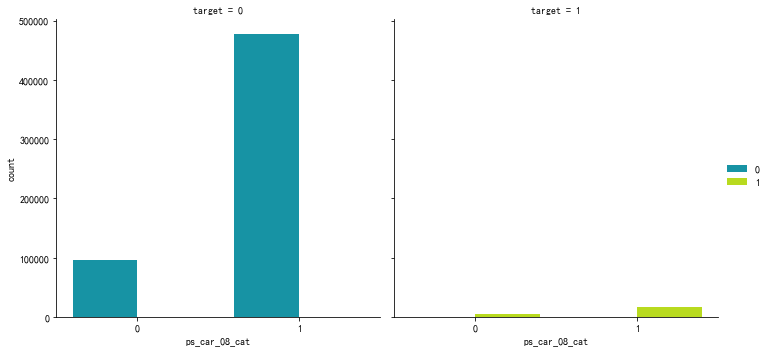

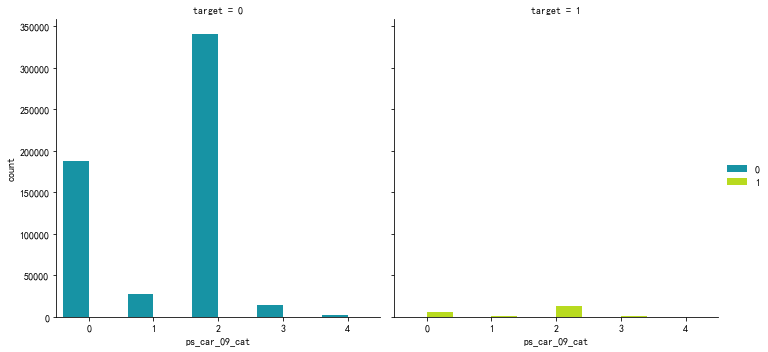

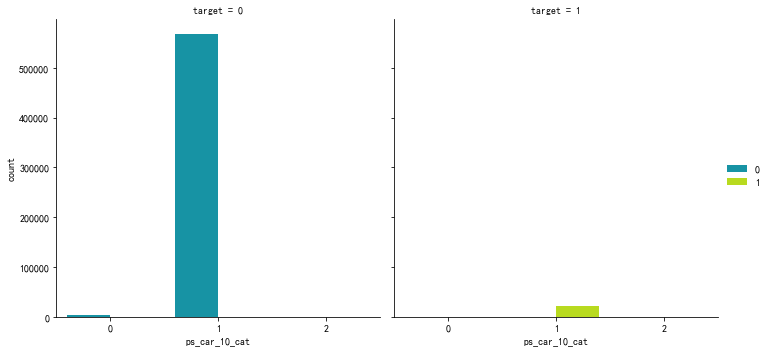

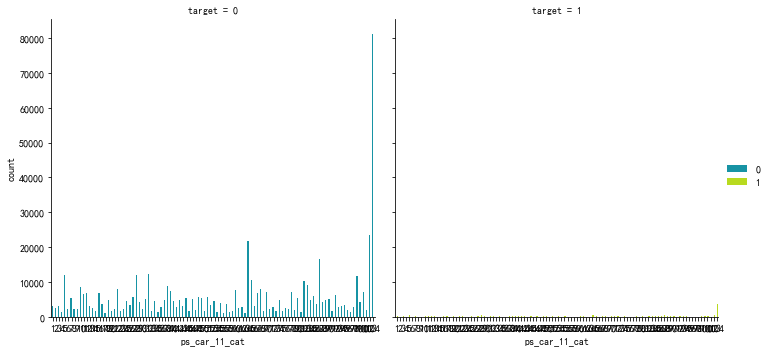

In [10]:
for col in cat_cols:
    g = sns.catplot(x=col, hue="target", col="target", data=train_data, kind="count", palette='nipy_spectral')
    g.add_legend()

In [11]:
train_data_new = train_data.iloc[:, 2:].copy()
train_data_new_Y = train_data['target']
test_data_new = test_data.iloc[:, 1:].copy()
#对类别数据数据处理
train_data_new=pd.get_dummies(data=train_data_new, columns=cat_cols, drop_first=True)
test_data_new=pd.get_dummies(data=test_data_new, columns=cat_cols, drop_first=True)

In [12]:
#对连续数据进行处理
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_data_new = scaler.fit_transform(train_data_new)
test_data_new = scaler.transform(test_data_new)

In [33]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, accuracy_score, confusion_matrix
def metrics(preds,preds_proba, true):
    accuracy = accuracy_score(true, preds)
    recall = recall_score(true, preds)
    f1score = f1_score(true, preds)
    cf = confusion_matrix(true, preds)
    NE = (-1) / len(preds) * sum(((1+true.values)/2 * np.log(preds_proba) +  (1-true.values)/2 * np.log(1 - preds_proba)))
    print("Normalized Cross Entropy " + str(NE))
    print('accuracy: {}, recall: {}, f1-score: {}'.format(accuracy, recall, f1score))
    print('Confusion matrix', cf)

In [14]:
from sklearn.model_selection import train_test_split
# 将样本集分成测试集和训练集
X_train, X_valid, y_train, y_valid = train_test_split(train_data_new, train_data_new_Y, test_size=0.8)
X_train, X_train_lr, y_train, y_train_lr = train_test_split(X_train, y_train, test_size=0.5)

In [32]:
n_estimator = 20
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve

def RF_LR_model(X_train, y_train, X_train_lr, y_train_lr, X_valid, y_valid, class_weight=''):
    #RF+LR
    # 基于随机森林的监督变换
    rf = RandomForestClassifier(max_depth=3, n_estimators=n_estimator)
    rf.fit(X_train, y_train)
    # 得到OneHot编码
    rf_enc = OneHotEncoder(categories='auto')
    rf_enc.fit(rf.apply(X_train))
    # 使用OneHot编码作为特征，训练LR
    rf_lm =LogisticRegression(solver='lbfgs', max_iter=1000,class_weight=class_weight)
    rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)
    # 使用LR进行预测
    prediction = rf_lm.predict(rf_enc.transform(rf.apply(X_valid)))
    y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_valid)))[:, 1]
    metrics(prediction, y_pred_rf_lm, y_valid)
    fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_valid, y_pred_rf_lm)
    return fpr_rf_lm, tpr_rf_lm, rf_enc, rf_lm, rf

fpr_rf_lm, tpr_rf_lm, rf_enc, rf_lm, rf= RF_LR_model(X_train, y_train, X_train_lr, y_train_lr, X_valid, y_valid)

Normalized Cross Entropy 1.7775205783228276
accuracy: 0.963649536930088, recall: 5.778342771293193e-05, f1-score: 0.00011553347582462019
Confusion matrix [[458860      4]
 [ 17305      1]]


可以看出因为样本不均衡，recall和f都非常低，针对样本不均衡处理方法大致有两个方向，一个是对样本进行上/下采样(imblearn)，二是调节模型参数在损失函数上对不同样本加上权重

In [34]:
#调整模型参数，使用class_weight调整样本损失函数上的权重
RF_LR_model(X_train, y_train, X_train_lr, y_train_lr, X_valid, y_valid, class_weight='balanced')

Normalized Cross Entropy 0.7229714247543058
accuracy: 0.6361992565680324, recall: 0.5163527100427597, f1-score: 0.09352024824309405
Confusion matrix [[294003 164861]
 [  8370   8936]]


(array([0.00000000e+00, 2.17929495e-06, 1.08964748e-05, 1.08964748e-05,
        2.61515395e-05, 2.61515395e-05, 5.66616688e-05, 5.66616688e-05,
        6.10202587e-05, 6.31995537e-05, 9.15303881e-05, 9.15303881e-05,
        9.37096830e-05, 9.37096830e-05, 1.00247568e-04, 1.04606158e-04,
        1.06785453e-04, 1.11144043e-04, 1.30757697e-04, 1.30757697e-04,
        1.41654172e-04, 1.41654172e-04, 1.48192057e-04, 1.48192057e-04,
        1.59088532e-04, 1.59088532e-04, 1.78702186e-04, 1.78702186e-04,
        1.83060776e-04, 1.89598661e-04, 1.89598661e-04, 2.09212316e-04,
        2.11391611e-04, 2.31005265e-04, 2.31005265e-04, 2.37543150e-04,
        2.41901740e-04, 2.61515395e-04, 2.61515395e-04, 2.70232574e-04,
        2.70232574e-04, 3.00742704e-04, 3.00742704e-04, 3.15997768e-04,
        3.15997768e-04, 3.26894243e-04, 3.26894243e-04, 3.31252833e-04,
        3.44328603e-04, 3.44328603e-04, 3.55225078e-04, 3.55225078e-04,
        3.72659437e-04, 3.72659437e-04, 3.90093797e-04, 3.900937

通过调整参数可以看出，虽然accuracy下降，f1值和recall都有所提高

In [35]:
#GBDT+LR
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
def GBDT_LR_model(X_train, y_train, X_train_lr, y_train_lr, X_valid, y_valid, class_weight=''):
    # 基于GBDT监督变换
    grd = GradientBoostingClassifier(n_estimators=n_estimator)
    grd.fit(X_train, y_train)
    # 得到OneHot编码
    grd_enc = OneHotEncoder(categories='auto')

    temp = grd.apply(X_train)
    np.set_printoptions(threshold=np.inf)  
    grd_enc.fit(grd.apply(X_train)[:, :, 0])
    #print(grd_enc.get_feature_names()) # 查看每一列对应的特征
    # 使用OneHot编码作为特征，训练LR
    grd_lm =LogisticRegression(solver='lbfgs', max_iter=1000,class_weight=class_weight)
    grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)
    # 使用LR进行预测
    prediction = grd_lm.predict(grd_enc.transform(grd.apply(X_valid)[:, :, 0]))
    y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(X_valid)[:, :, 0]))[:, 1]
    metrics(prediction, y_pred_grd_lm, y_valid)
    fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_valid, y_pred_grd_lm)
    return fpr_grd_lm, tpr_grd_lm, grd_enc, grd_lm, grd

fpr_grd_lm, tpr_grd_lm, grd_enc, grd_lm, grd = GBDT_LR_model(X_train, y_train, X_train_lr, y_train_lr, X_valid, y_valid, 'balanced')

Normalized Cross Entropy 0.7181081200798086
accuracy: 0.6325219984459332, recall: 0.5257714087599676, f1-score: 0.09420229837457295
Confusion matrix [[292089 166775]
 [  8207   9099]]


In [18]:
#进行样本的采样
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

sm_methods = [SMOTE,RandomUnderSampler,RandomOverSampler]
for sm in sm_methods:
    print('------------------------------------------')
    sm = sm(random_state=42)
    X_train_resampled, y_train_resampled = sm.fit_sample(train_data_new, train_data_new_Y)
    X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(X_train_resampled, y_train_resampled, test_size=0.8)
    X_train_2, X_train_lr_2, y_train_2, y_train_lr_2 = train_test_split(X_train_2, y_train_2, test_size=0.5)
    print(str(sm), 'results:')
    print('training resampled shape', X_train_resampled.shape)
    print('value counts in each class', y_train_resampled.value_counts())
    print('RF_LR_model:')
    fpr_rf_lm, tpr_rf_lm, rf_enc, rf_lm, rf = RF_LR_model(X_train_2, y_train_2, X_train_lr_2, y_train_lr_2, X_valid_2, y_valid_2, class_weight='balanced')
    print('GBDT_LR_model:')
    fpr_grd_lm, tpr_grd_lm, grd_enc, grd_lm, grd = GBDT_LR_model(X_train_2, y_train_2, X_train_lr_2, y_train_lr_2, X_valid_2, y_valid_2, 'balanced')


------------------------------------------
SMOTE(random_state=42) results:
training resampled shape (1147036, 204)
value counts in each class 1    573518
0    573518
Name: target, dtype: int64
RF_LR_model:
accuracy: 0.867690537243265, recall: 0.868395536240746, f1-score: 0.8675571748817776
Confusion matrix [[398571  61148]
 [ 60263 397647]]
GBDT_LR_model:
accuracy: 0.9779104627251318, recall: 1.0, f1-score: 0.9774105113003165
Confusion matrix [[458834  20270]
 [     0 438525]]
------------------------------------------
RandomUnderSampler(random_state=42) results:
training resampled shape (43388, 204)
value counts in each class 1    21694
0    21694
Name: target, dtype: int64
RF_LR_model:
accuracy: 0.5747745671400997, recall: 0.5769980506822612, f1-score: 0.5696291112666201
Confusion matrix [[10183  7599]
 [ 7161  9768]]
GBDT_LR_model:
accuracy: 0.57293077122526, recall: 0.5767026603124812, f1-score: 0.5632806976196088
Confusion matrix [[10327  7807]
 [ 7017  9560]]
--------------------

因为使用的是resampled切分的y_valid_2做了验证，所以整体的f1和recall值都提高了很多，本身样本均衡了，但是如果用resampled之前的y_valid验证集的话，f1还是在1%左右

In [19]:
y_pred_grd_lm = grd_lm.predict_proba(grd_enc.transform(grd.apply(test_data_new)[:, :, 0]))[:, 1]
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(test_data_new)))[:, 1]

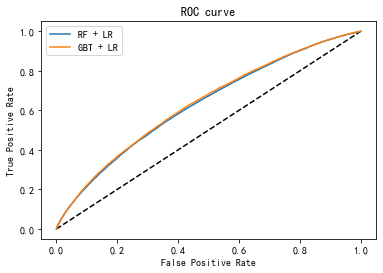

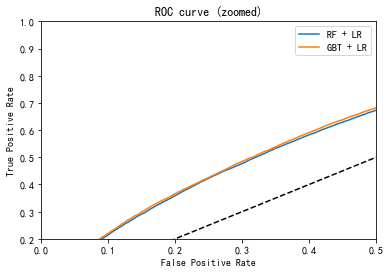

In [20]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_lr, tpr_lr, label='LR')
#plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
#plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# 将左上角放大显示
plt.figure(2)
plt.xlim(0, 0.5)
plt.ylim(0.2, 1)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_lr, tpr_lr, label='LR')
#plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR')
#plt.plot(fpr_grd, tpr_grd, label='GBT')
plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (zoomed)')
plt.legend(loc='best')
plt.show()

不太明白两个曲线为啥会重合？